<a href="https://colab.research.google.com/github/takumi-maker/bert/blob/main/dms_trenddetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import math
import statistics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

In [2]:
def func_param(x_t,r,x_list,mu_1,C_1,order):
  mu_t = r*mu_1+(1-r)*x_t
  C_t_list = []
  for i in range(order+1):
    C_t = r*C_1[i]+(1-r)*(x_t-mu_t)*(x_list[i]-mu_t)

    C_t_list.append(C_t)
  if order == 1:
    C0 = C_t_list[0]
    C1 = C_t_list[1]
    a1 = C1/C0
    sigma_2 = C0 - a1*C1

  return mu_t,C_t_list,sigma_2

In [3]:
def func_dms(x_t,mu_1,sigma2_1):
  dm = (x_t - mu_1)**2 / sigma2_1
  dms = (x_t - mu_1)**2 / sigma2_1 * np.sign(x_t - mu_1)
  return dms

In [62]:
df_1 = pd.read_csv("通貨データセット1.csv")
df_1 = df_1.drop(df_1.columns[0], axis=1)
columns_len = len(df_1.columns)
length = len(df_1)
df_1
y_df = df_1
y_df = y_df.drop('USDJPY',axis=1)
#y_df = y_df.drop('EURJPY',axis=1)
y_df = y_df.drop('EUDUSD',axis=1)
y_df = y_df.drop('AUDUSD',axis=1)
y_df = y_df.drop('AUDJPY',axis=1)
y_df = y_df.drop('AUDEUR',axis=1)
y_df = y_df.drop('GBPUSD',axis=1)
y_df = y_df.drop('EURGBP',axis=1)
y_df

,EURJPY
0,126.27
1,126.31
2,126.74
3,127.12
4,127.11
...,...
769,156.50
770,156.83
771,157.55
772,156.64


In [63]:
selected_column1 = "EURJPY"

first_val1 =df_1[selected_column1][0]
comission1 = 0.1/first_val1

y_df[selected_column1] = y_df[selected_column1]/first_val1
y_df

,EURJPY
0,1.000000
1,1.000317
2,1.003722
3,1.006732
4,1.006652
...,...
769,1.239408
770,1.242021
771,1.247723
772,1.240516


100


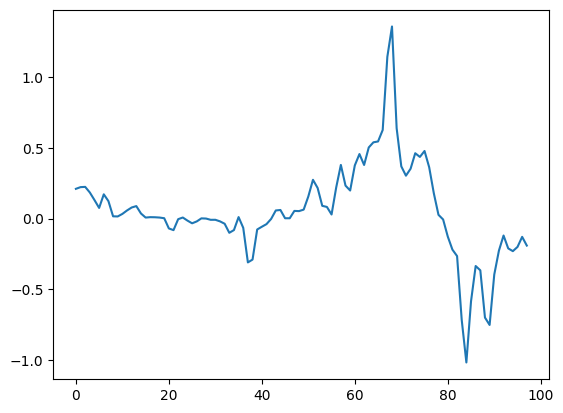

SharpRatio: -0.009016786575501437
-0.7400000000000574
200


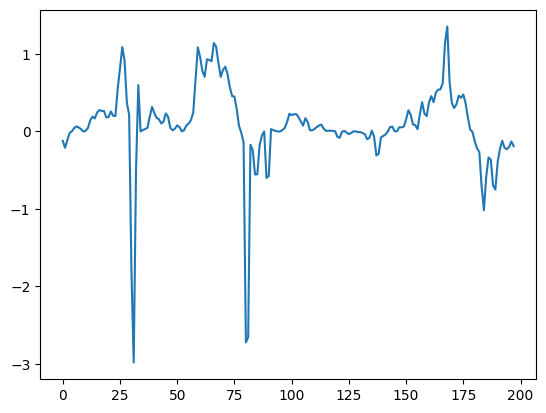

SharpRatio: -0.03972177871673168
-6.659999999999985
300


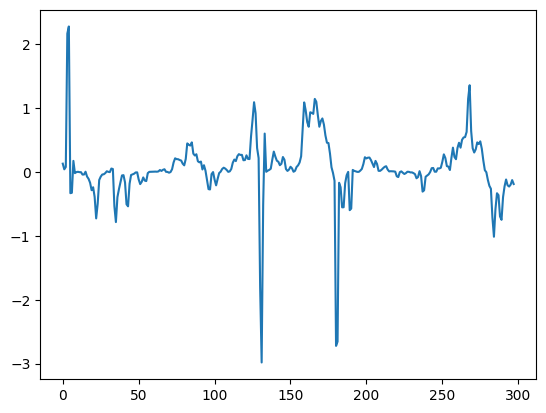

SharpRatio: -0.005819405983216433
-1.639999999999876
400


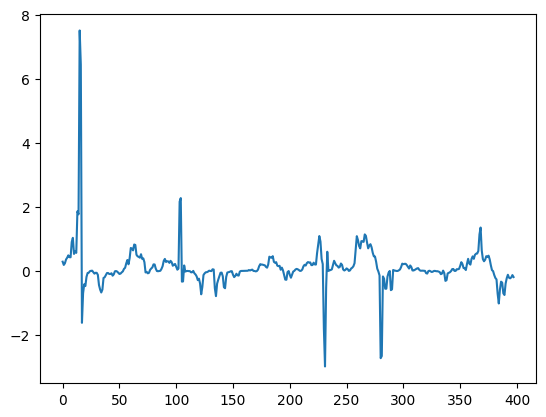

SharpRatio: 0.02420535962920616
9.44000000000005


In [64]:
#変更後
from sklearn.linear_model import LinearRegression
import statsmodels
import statsmodels.api
import matplotlib.pyplot as plt
from sklearn import preprocessing
import cvxpy as cp

magic_num = 30
estimate_num = 150
predict_time = 30
r = 0.9
order_num =1
window_size = 3

comission = comission1
amendment = first_val1


df_array = y_df.to_numpy()


for i in range(1,5):
  total_num = 100*i
  print(total_num)

  total_list = []
  y_list = []
  current_list = []
  result_list = []
  dms_list = []
  return_list = []
  predict_flag2 = 0
  change_num = 0
  for j in range(magic_num-1,len(df_array)):
    X_list = []
    for k in range(magic_num):
      X_list.append(df_array[j-k])
    try:
      y_return = (df_array[j+1]-df_array[j])*1
    except:
      y_return = [0]
    #current_list.append(df_array[j-1])
    y_list.append(y_return)

    total_list.append(X_list)
  #print(total_list)
  #print(y_list)
  total_list = np.array(total_list)
  y_list = np.array(y_list)
  #current_list = np.array(current_list)
  #print(total_list)
  #print(total_list.shape)
  #print(y_list.shape)
  for j in range(len(total_list)):
    if j <= len(total_list)-1-total_num:
      continue
    #print(j)
    X_array = np.array(total_list[j])
    y_array = y_list[j]
    X_array_1 = np.array(total_list[j-1])
    y_array_1 = y_list[j-1]
    #current_X = np.array(current_list[j])

    mu_1 = sum(X_array_1) / len(X_array_1)
    C_1_list = []
    for k in range(order_num+1):
      C_1_sub = []
      for l in range(len(X_array_1)-1):
        C_1 = (X_array_1[l]-mu_1)*(X_array_1[l+k]-mu_1)
        C_1_sub.append(C_1)
      C_1_list.append(sum(C_1_sub))
    #print(C_1_list)
    #print(X_array)
    mu_t,C_t_list,sigma_2 = func_param(X_array_1[0],r,X_array_1,mu_1,C_1_list,order_num)


    mu_1 = mu_t
    C_1 = C_t_list
    sigma_2_1 = sigma_2
    dms = func_dms(X_array[0],mu_1,sigma_2_1)
    dms_list.append(dms)
    result_list.append(y_array[0])
    mu_t,C_t_list,sigma_2 = func_param(X_array[0],r,X_array,mu_1,C_1_list,order_num)

  #plt.plot(dms_list)
  #plt.show()
  ave_dms_list=[]
  predict_flag2 = 0
  for j in range(window_size-1,len(dms_list)):
    ave_dms = sum(dms_list[j-window_size+1:j])/len(dms_list[j-window_size+1:j])
    ave_dms_list.append(ave_dms)
    if ave_dms > 0.0:
      predict_flag = -1
    else:
      predict_flag = 1

    if predict_flag==predict_flag2:
      return_ = predict_flag*result_list[j]
      return_list.append(return_)
      predict_flag2 = predict_flag
    else:
      return_ = predict_flag*result_list[j] -comission
      return_list.append(return_)
      predict_flag2 = predict_flag
    #return_ = predict_flag*result_list[j] -comission
    #print(return_)
    #return_list.append(return_)
  plt.plot(ave_dms_list)
  plt.show()

  R_sum = sum(return_list)*amendment
  SR = np.mean(np.array(return_list))/np.std(np.array(return_list))
  print("SharpRatio:",SR)
  print(R_sum)


100


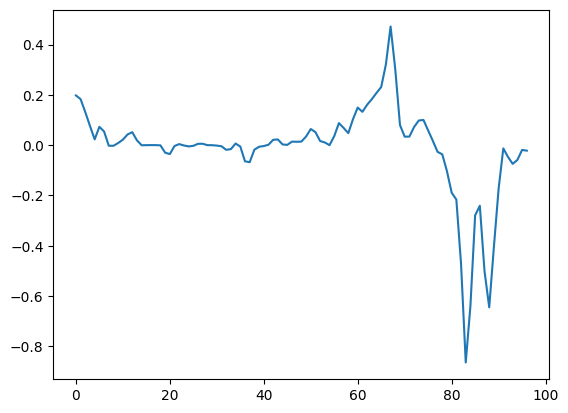

SharpRatio: 0.005996100261763204
0.4899999999999697
200


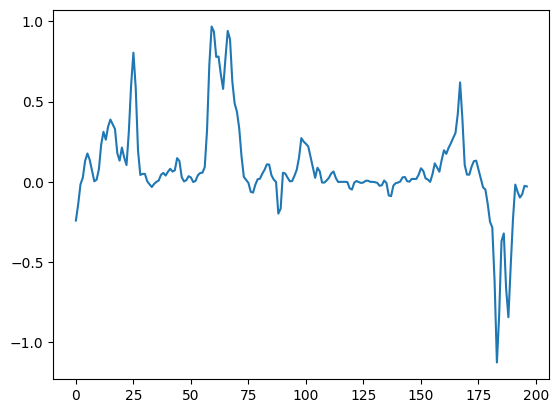

SharpRatio: 0.0194258902367459
3.230000000000122
300


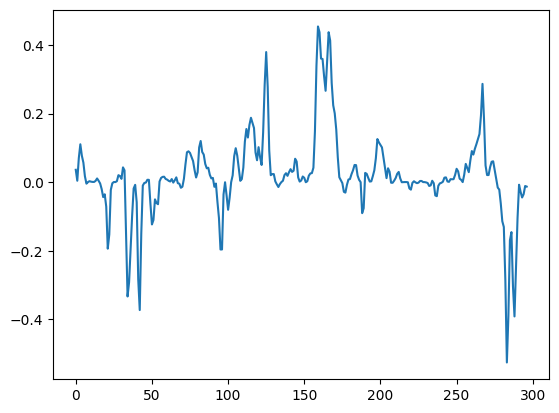

SharpRatio: 0.0323121909131624
9.100000000000142
400


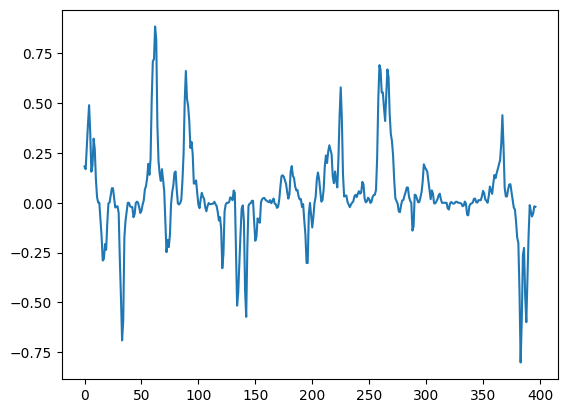

SharpRatio: 0.06634531404903014
25.69000000000023


In [65]:
#変更前
from sklearn.linear_model import LinearRegression
import statsmodels
import statsmodels.api
import matplotlib.pyplot as plt
from sklearn import preprocessing
import cvxpy as cp

magic_num = 30
estimate_num = 150
predict_time = 30
r = 0.9
order_num =1
window_size = 3


comission = comission1
amendment = first_val1

df_array = y_df.to_numpy()


for i in range(1,5):
  total_num = 100*i
  print(total_num)

  total_list = []
  y_list = []
  current_list = []
  result_list = []
  dms_list = []
  return_list = []
  predict_flag2 = 0
  change_num = 0
  for j in range(magic_num-1,len(df_array)):
    X_list = []
    for k in range(magic_num):
      X_list.append(df_array[j-k])
    try:
      y_return = (df_array[j+1]-df_array[j])*1
    except:
      y_return = [0]
    #current_list.append(df_array[j-1])
    y_list.append(y_return)

    total_list.append(X_list)
  #print(total_list)
  #print(y_list)
  total_list = np.array(total_list)
  y_list = np.array(y_list)
  #current_list = np.array(current_list)
  #print(total_list)
  #print(total_list.shape)
  #print(y_list.shape)
  for j in range(len(total_list)):
    if j <= len(total_list)-1-total_num:
      continue
    #print(j)
    X_array = np.array(total_list[j])
    y_array = y_list[j]
    #current_X = np.array(current_list[j])
    if j == len(total_list)-total_num:
      mu_1 = sum(X_array) / len(X_array)
      C_1_list = []
      for k in range(order_num+1):
        C_1_sub = []
        for l in range(len(X_array)-1):
          C_1 = (X_array[l]-mu_1)*(X_array[l+k]-mu_1)
          C_1_sub.append(C_1)
        C_1_list.append(sum(C_1_sub))
      #print(C_1_list)
      #print(X_array)
      mu_t,C_t_list,sigma_2 = func_param(X_array[0],r,X_array,mu_1,C_1_list,order_num)

    else:
      mu_1 = mu_t
      C_1 = C_t_list
      sigma_2_1 = sigma_2
      dms = func_dms(X_array[0],mu_1,sigma_2_1)
      dms_list.append(dms)
      result_list.append(y_array[0])
      mu_t,C_t_list,sigma_2 = func_param(X_array[0],r,X_array,mu_1,C_1_list,order_num)

  #plt.plot(dms_list)
  #plt.show()
  ave_dms_list=[]
  predict_flag2 = 0
  for j in range(window_size-1,len(dms_list)):
    ave_dms = sum(dms_list[j-window_size+1:j])/len(dms_list[j-window_size+1:j])
    ave_dms_list.append(ave_dms)
    if ave_dms > 0.0:
      predict_flag = -1
    else:
      predict_flag = 1

    if predict_flag==predict_flag2:
      return_ = predict_flag*result_list[j]
      return_list.append(return_)
      predict_flag2 = predict_flag
    else:
      return_ = predict_flag*result_list[j] -comission
      return_list.append(return_)
      predict_flag2 = predict_flag
    #return_ = predict_flag*result_list[j] -comission
    #print(return_)
    #return_list.append(return_)
  plt.plot(ave_dms_list)
  plt.show()

  R_sum = sum(return_list)*amendment
  SR = np.mean(np.array(return_list))/np.std(np.array(return_list))
  print("SharpRatio:",SR)
  print(R_sum)


In [ ]:
from sklearn.linear_model import LinearRegression
import statsmodels
import statsmodels.api
import matplotlib.pyplot as plt
from sklearn import preprocessing
import cvxpy as cp

magic_num = 180
estimate_num = 150
predict_time = 30


comission = comission1
amendment = first_val1

df_array = y_df.to_numpy()


for i in range(1,5):
  total_num = 100*i
  print(total_num)

  total_list = []
  y_list = []
  current_list = []
  result_list = []
  predict_flag2 = 0
  change_num = 0
  for j in range(magic_num-1,len(df_array)):
    X_return_list = []
    for k in range(1,magic_num):
      X_return_list.append(df_array[j-k])
    y_return = (df_array[j]-df_array[j-1])*1
    current_list.append(df_array[j-1])
    y_list.append(y_return)
    X_list2 = list(reversed(X_return_list))
    total_list.append(X_list2)

  total_list = np.array(total_list)
  y_list = np.array(y_list)
  current_list = np.array(current_list)
  #print(total_list)
  #print(total_list.shape)
  #print(y_list.shape)
  for j in range(len(total_list)):
    if j <= len(total_list)-1-total_num:
      continue
    #print(j)
    X_array = np.array(total_list[j])
    y_array = y_list[j]
    current_X = np.array(current_list[j])
    #print(X_array.shape)
    #print(y_array.shape)
    #print("#")

    #この後Xを転置してDMDに突っ込む
    X_DMD = X_array.T
    dmd = DynamicModeDecomposition(rank=15, svd_rank=2,T=magic_num)

    dmd.fit(X_DMD)
    X_pred = dmd.predict(predict_time)
    #print(X_pred.real)

    y_pred = X_pred[0,0].real
    #print(y_pred
    current_y = current_X[0]
    retrun_ = y_array[0]
    #print(current_y)

    if y_pred - current_y >= 0.0000:
      predict_flag = 0
    elif y_pred - current_y <-0.0000:
      predict_flag = 1
    else:
      predict_flag = predict_flag2

    if predict_flag*predict_flag2 >=0 :
      result_r = retrun_*predict_flag
      result_list.append(result_r)
      predict_flag2 = predict_flag
    else:
      result_r = retrun_*predict_flag-comission
      #result_r = retrun_*predict_flag-0
      result_list.append(result_r)
      predict_flag2 = predict_flag
      change_num +=1
      #print("change_point:",j)

  R_sum = sum(result_list)*amendment
  SR = np.mean(np.array(result_list))/np.std(np.array(result_list))
  print("SharpRatio:",SR)
  print(R_sum)
  print("change_num:",change_num)

100


NameError: name 'DynamicModeDecomposition' is not defined